In [1]:
import dataloader
import utilities
import features
import transcribe
import evaluate
import matplotlib.pyplot as plt
import numpy as np 
import scipy
import librosa.display

PATH = "/home/max/ET-TI/Masterarbeit/mirdata/"
gui = dataloader.MIRDatasetGUI(PATH);

Output()

Template based chord recognition approach with a quantized chromagram

In [49]:
audiopath,(ref_intervals,ref_labels) = gui.getSelectedTrack()
t,sig = utilities.loadAudio(audiopath)
t_chroma, chroma = features.crpChroma(sig,nCRP=55)

Evaluation of correlation </br>
beatinformation is not suited for </br>
Post-filtering: if a chord duration is too short, try search for a better match 

In [39]:
t_chroma, chroma = features.crpChroma(sig,nCRP=55)
chroma_cq = librosa.feature.chroma_cqt(y=sig, sr=22050,bins_per_octave=36)
chroma_cq = chroma_cq / (np.sum(chroma_cq,axis=0)+np.finfo(float).eps)
t_chroma_cq = np.linspace(sig.start,sig.stop,chroma_cq.shape[1])

majmin: 0.01, segmentation: 0.71


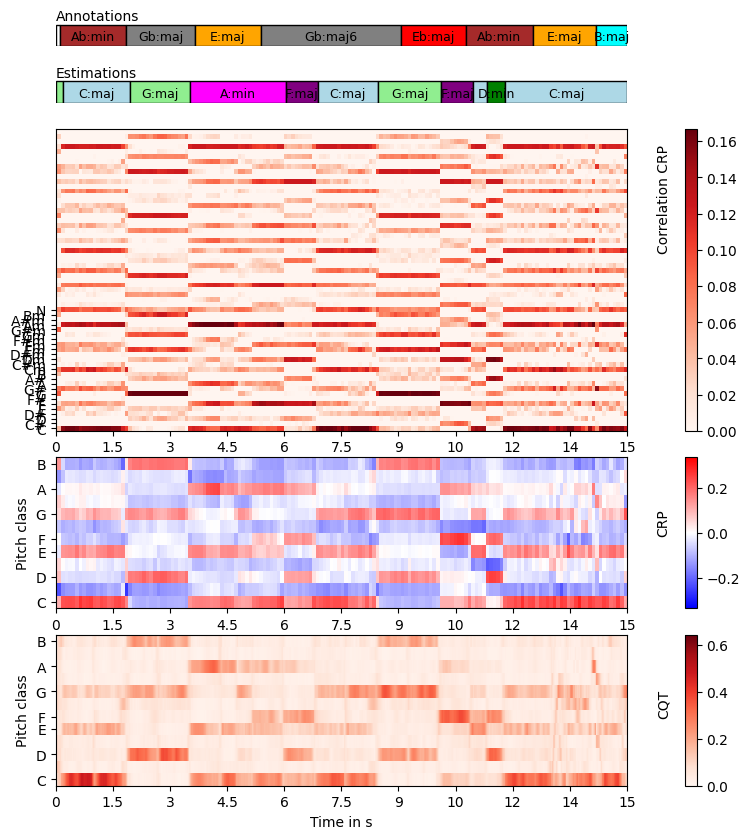

In [47]:

#### Pre-Filtering
# beat-synchronous filtering
# chroma = utilities.smoothChromagram(t_chroma,chroma,beats)
# median filter
# chroma = scipy.ndimage.median_filter(chroma, size=(1, 5))

templates,labels = utilities.createChordTemplates(template_type="majmin_sevenths") # majmin ,triads,triads_extended, majmin_sevenths
correlation = np.matmul(templates.T,chroma)
#### post filter
# median filter
# correlation = scipy.ndimage.median_filter(correlation, size=(1, 17))
# gaussian blur  -> lowpass filter?
# correlation = scipy.ndimage.gaussian_filter1d(correlation,1,axis=1)
# crop negative values
correlation = np.clip(correlation,a_min=0,a_max=10)
estimated_labels = [labels[np.argmax(correlation[:,i])] for i in range(chroma.shape[1])]
est_intervals,est_labels =  utilities.createChordIntervals(t_chroma,estimated_labels)
est_intervals,est_labels = transcribe.transcribeHMM(t_chroma,chroma,p=0.2,template_type="majmin")
# plot Templates
# fig,ax = plt.subplots(figsize=(8.27,5))
# librosa.display.specshow(templates.T,ax=ax, cmap="Reds")
# labels = ["C","D","E","F","G","A","B","Cm","Dm","Em","Fm","Gm","Am","Bm","N"]
# xticks = [0,2,4,5,7,9,11,12,14,16,17,19,21,23,24]
# ax.set_xticks(xticks)
# ax.set_xticklabels(labels)
# ax.set_yticks(xticks[:7])
# ax.set_yticklabels(labels[:7])
# ax.set_ylabel("pitch class")
# ax.set_xlabel("chord label")


fig,ax = plt.subplots(5,2,height_ratios=(1,1,10,5,5),width_ratios=(50,1),figsize=(8.27,10))
utilities.plotChordAnnotations(ax[0,0],(ref_intervals,ref_labels),(0,15))
ax[0,0].text(0,1.7,"Annotations")
utilities.plotChordAnnotations(ax[1,0],(est_intervals,est_labels),(0,15))
ax[1,0].text(0,1.7,"Estimations")
img = librosa.display.specshow(correlation,x_coords=t_chroma.T,x_axis='time', vmin=0,vmax=np.max(correlation),cmap='Reds', ax=ax[2,0])

labels = ["C","C#","D","D#","E","F","F#","G","G#","A","A#","B","Cm","C#m","Dm","D#m","Em","Fm","F#m","Gm","G#m","Am","A#m","Bm","N"]
yticks = np.arange(0,25,1)
# ax[2,0].plot(t_chroma,10*d_mkl)
ax[2,0].set_yticks(yticks)
ax[2,0].set_yticklabels(labels)
ax[2,0].set_xlim([0,15])

ax[2,1].text(-2.5,0.1,"Correlation CRP",rotation="vertical")
fig.colorbar(img,cax=ax[2,1],cmap="bwr")
img = utilities.plotChromagram(ax[3,0],t_chroma,chroma,None,None,vmin=-np.max(chroma),vmax=np.max(chroma),cmap='bwr')
fig.colorbar(img,cax=ax[3,1],cmap="bwr")
ax[3,0].set_xlim([0,15])
ax[3,1].text(-2.5,0,"CRP",rotation="vertical")
ax[0,1].set_axis_off()
ax[1,1].set_axis_off()
img = utilities.plotChromagram(ax[4,0],t_chroma_cq,chroma_cq,None,None,vmin=0,vmax=np.max(chroma_cq))#
ax[4,0].set_xlim([0,15])
ax[4,1].text(-2.5,0.3,"CQT",rotation="vertical")
fig.colorbar(img,cax=ax[4,1],cmap="Reds")
score,seg = evaluate.evaluateTranscription(est_intervals,est_labels,ref_intervals,ref_labels,scheme="majmin")
print(f"majmin: {score}, segmentation: {seg}")